In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras==3.3.3

In [3]:
import os, cv2
import tensorflow as tf
# from model.rep_efficientnet_v2 import EfficientNetV2B3
import keras
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from model.losses import categorical_focal_crossentropy
from keras.utils import image_dataset_from_directory
import tensorflow as tf
import glob
import keras
import numpy as np
from keras import Sequential, Model
from keras.layers import Input, Layer, AveragePooling2D, Conv2D, BatchNormalization, Dropout, Dense, Flatten, ReLU, ZeroPadding2D
from tqdm import tqdm


def unfreeze_model(model, unfree=False, precent=10):
    length = len(model.layers)
    top_layer = int(length * (precent/100))
    print("length : ", length, "top_layer: ", top_layer, "int(precent/100): ", precent/100)
    if unfree:
        # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
        top_layer *= -1
        for layer in model.layers[top_layer:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
                print("Layer >> ", layer)
    return model


def load_images(dir_images, gray=False, dsize=(224, 224)):
    tasks = ('train', 'val')
    data, labels, tmp_paths = [], [],[]
    for _, task in tqdm(enumerate(tasks)):
        cates = os.listdir(os.path.join(dir_images, task))
        for cate in cates:
            files = os.listdir(os.path.join(dir_images, task, cate))
            for img_file in files:
                labels.append(cate)
                tmp_path = os.path.join(dir_images, task, cate, img_file);
                tmp_paths.append(os.path.join(task,cate,img_file))
                image = cv2.imread(tmp_path)
                image = cv2.resize(image, dsize)
                if gray:
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    data.append(gray_image)
                else:
                    data.append(image)
    return data, labels,tmp_paths


def scale_up_lora(inputs, units, lora_rank, lora_num_layer, activation=None, name='lora'):
    lora_denses = []
    for i in range(lora_num_layer):
        lora_denses.append(keras.layers.Dense(units, activation=activation,
                                              lora_rank=lora_rank, name=f'{name}_dense_{i}')(inputs))
    lora_denses.append(inputs)
    x_nlora = keras.layers.Add(name=f'{name}_add')(lora_denses)
    # x_activation = keras.activations.relu(x_nlora)
    x_bn = keras.layers.BatchNormalization()(x_nlora)
    return x_bn


def build_model(size, base_model):
    inputs = keras.Input(shape=(*size, 3))
    # x_rescaling = keras.layers.Rescaling(scale=1./127.5, offset=-1)(inputs)
    x_base_model = base_model(inputs, training=False)
    x_flatten = keras.layers.GlobalAveragePooling2D()(x_base_model)
    x_dropout1 = keras.layers.Dropout(0.3)(x_flatten)
    # x_activation = keras.activations.relu(x_dropout1)
    x_nlora = scale_up_lora(x_dropout1, units=x_dropout1.shape[1], lora_rank=6, lora_num_layer=4, activation='relu')
    # add_dense = keras.layers.Dense(1792,activation='relu')(x_dropout1)
    x_dropout2 = keras.layers.Dropout(0.3)(x_nlora)
    outputs = keras.layers.Dense(10, activation='softmax')(x_dropout2)
    model = keras.Model(inputs, outputs)
    # init_weights = model.get_weights()
    return model


In [4]:
import os
import shutil


def save_training(save_dir):
    os.makedirs(save_dir, exist_ok=True)
    length = len(glob.glob(save_dir + "/train*"))
    save_dir = os.path.join(save_dir, f'train{length+1}')
    os.makedirs(save_dir, exist_ok=True)
    print(">>>>>>>>>> ", save_dir)
    return save_dir


def get_cacll_back(save_dir):
    checkpoint_filepath = os.path.join(save_dir, 'best.weights.h5')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True)

    model_stop = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                            verbose=1,
                                            patience=10,
                                            mode='max',
                                            restore_best_weights=False),
    return [
        model_stop,
        model_checkpoint_callback
    ]

In [5]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# base_model = unfreeze_model(base_model, unfree=True, precent=30) # unfree 30% top layer
# base_model.summary(show_trainable=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

In [8]:
# temp model
model = build_model(base_model=base_model,size=(224, 224))
init_weights = model.get_weights()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[1][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_0 (Dense)      │ (None, 2048)           │      4,220,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_1 (Dense)      │ (None, 2048)           │      4,220,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_2 (Dense)      │ (None, 2048)           │      4,220,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_3 (Dense)      │ (None, 2048)           │      4,220,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_add (Add)            │ (None, 2048)           │              0 │ lora_dense_0[0][0],    │
│                           │                        │                │ lora_dense_1[0][0],    │
│                           │                        │                │ lora_dense_2[0][0],    │
│                           │                        │                │ lora_dense_3[0][0],    │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048)           │          8,192 │ lora_add[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2048)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10)             │         20,490 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40,500,106 (154.50 MB)

 Trainable params: 131,082 (512.04 KB)

 Non-trainable params: 40,369,024 (154.00 MB)

# Training with Train/Val

>>>>>>>>>>  /content/drive/MyDrive/DATASET/logs/hova10/train5


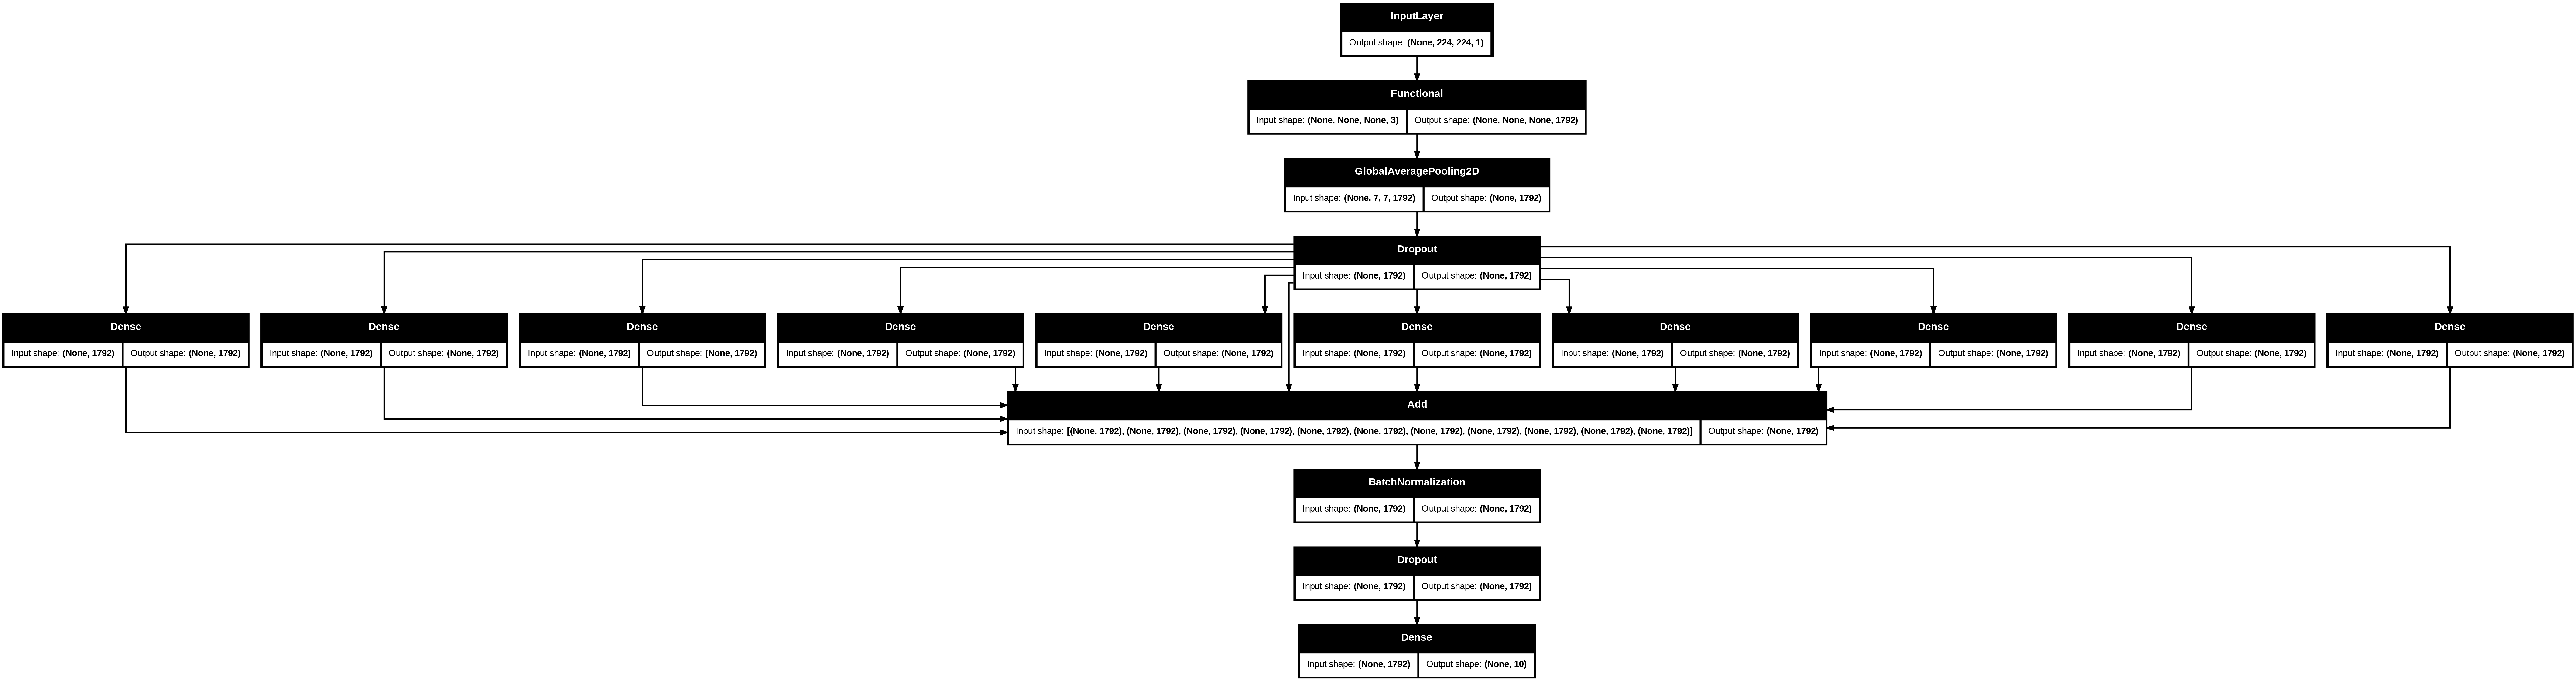

In [ ]:
save_path = "/content/drive/MyDrive/DATASET/logs/hova10"
save_history = save_training(save_path)
keras.utils.plot_model(model, to_file=os.path.join(save_history, 'model.png'), show_shapes=True)

In [ ]:
focal = keras.losses.categorical_focal_crossentropy
METRICS = [
    # tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='Top1'),
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
]

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=[focal], metrics = METRICS)
my_callbacks = get_cacll_back(save_dir=save_history)

In [ ]:
train_dir = "/content/drive/MyDrive/Computer_Vision/HOVA10/train"
test_dir = "/content/drive/MyDrive/Computer_Vision/HOVA10/val"
size = (224,224)
batch_size = 32
train = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)
val = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)

Found 1617 files belonging to 10 classes.
Found 674 files belonging to 10 classes.


In [ ]:
model.set_weights(init_weights)
epoch = 100
history = model.fit(
        x = train,
        epochs = epoch,
        validation_data = val,
        batch_size=batch_size,
        shuffle=True,
        callbacks=my_callbacks,
        # steps_per_epoch = len(train.file_paths) // batch_size,
        # validation_steps=len(val.file_paths) // batch_size,
        # sample_weight=train.sample_weight
        # workers=5
        #  class_weight = class_weight
)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - categorical_accuracy: 0.1968 - loss: 0.5915 - val_categorical_accuracy: 0.5008 - val_loss: 0.2964
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - categorical_accuracy: 0.5142 - loss: 0.3049 - val_categorical_accuracy: 0.7306 - val_loss: 0.1438
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - categorical_accuracy: 0.6941 - loss: 0.1786 - val_categorical_accuracy: 0.7976 - val_loss: 0.1035
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - categorical_accuracy: 0.7462 - loss: 0.1509 - val_categorical_accuracy: 0.8326 - val_loss: 0.0911
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - categorical_accuracy: 0.7647 - loss: 0.1267 - val_categorical_accuracy: 0.8387 - val_loss: 0.0862
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.8300 - loss: 0.0978 - val_categorical_accuracy: 0.8524 - val_loss: 0.0840
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - categorical_accuracy: 0.8132 - loss: 0

In [ ]:
model.save_weights(os.path.join(save_history, 'last.weights.h5'))
print("save to >>>>>>>>>> ", os.path.join(save_path, 'last.weights.h5'))

save to >>>>>>>>>>  /content/drive/MyDrive/DATASET/logs/hova10/last.weights.h5


In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)
hist_csv_file = os.path.join(save_history, 'history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False)

Index(['categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss'], dtype='object')


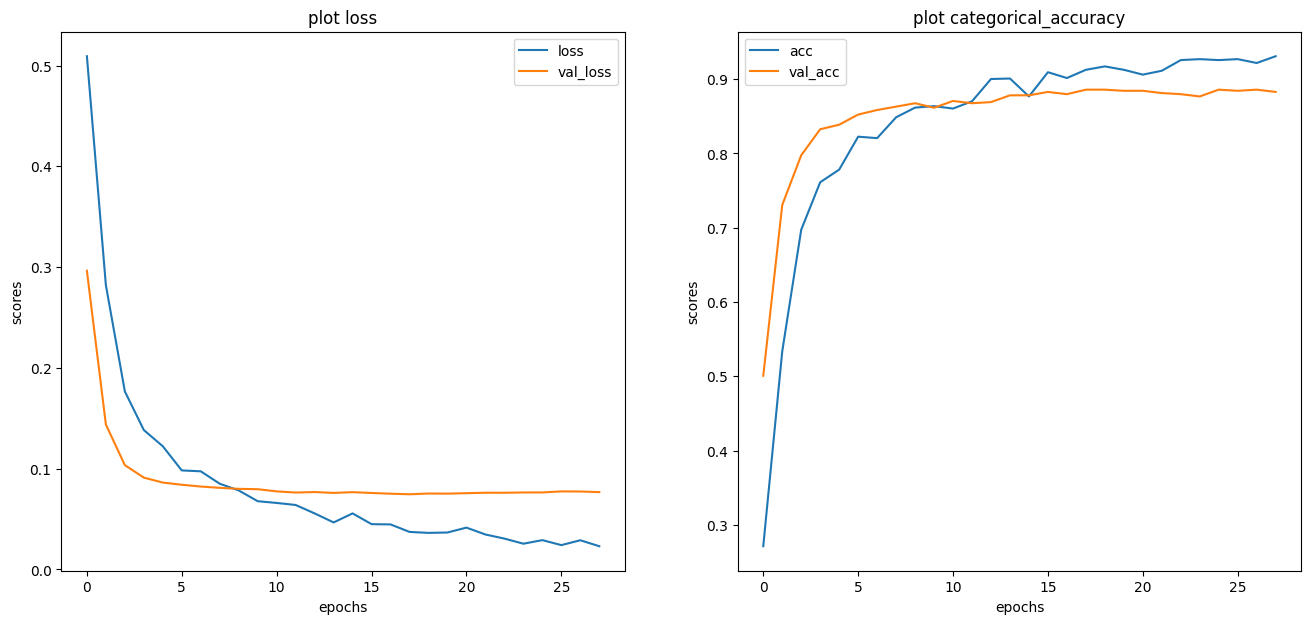

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_train = pd.read_csv(hist_csv_file)
print(df_train.columns)

loss = df_train['loss'].values
val_loss = df_train['val_loss'].values

acc = df_train['categorical_accuracy'].values
val_acc = df_train['val_categorical_accuracy'].values

logs_train = [
    [[loss, val_loss, "plot loss", ["loss", "val_loss"]], [acc, val_acc, "plot categorical_accuracy", ["acc", "val_acc"]]],
]

fig, axs = plt.subplots(1, 2, figsize=(16, 7), squeeze=False)
eps = [i for i in range(0, len(loss))]
for row, sub_logs_train in enumerate(logs_train):
    for col, (train, val, title, legend) in enumerate(sub_logs_train):
        # print(legend)
        axs[row][col].plot(eps, train)
        axs[row][col].plot(eps, val)
        axs[row][col].set_title(title)
        axs[row][col].legend(legend)
        axs[row][col].set_xlabel("epochs")
        axs[row][col].set_ylabel("scores")

fig.show()

In [ ]:
train_dir = "/content/drive/MyDrive/DATASET/HOVA10/train"
test_dir = "/content/drive/MyDrive/DATASET/HOVA10/val/"
size = (224,224)
batch_size = 32
train = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)
val = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)

Found 1533 files belonging to 10 classes.
Found 657 files belonging to 10 classes.


In [ ]:
print("Load model from ", os.path.join(save_history, "best.weights.h5"))
model.load_weights(os.path.join(save_history, "best.weights.h5"))
val_metrics = model.evaluate(val, batch_size=batch_size)
print("Val Loss: ", val_metrics[0])
print("Val Acc: ", val_metrics[1])

Load model from  /content/drive/MyDrive/DATASET/logs/hova10/train12/best.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step - categorical_accuracy: 0.8886 - loss: 0.0727
Val Loss:  0.0745832622051239
Val Acc:  0.8858447670936584


# Training KFOLD

LOAD FULL DATA AND SAVE TWO COLUMNS: PATH, DATA TO CSV

In [ ]:
#fix load_images function to get path of image
images, labels,tmp_paths = load_images(dir_images="/content/drive/MyDrive/Computer_Vision/HOVA10", gray=False, dsize=(224, 224))
images = np.array(images)
labels = np.array(labels)
tmp_paths = np.array(tmp_paths)
images.shape, labels.shape, tmp_paths.shape

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
# setup KFOLD
lb = preprocessing.LabelBinarizer()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10000)
skf.get_n_splits(images, labels)
print(skf)

In [ ]:

import pandas as pd
import os
for i, (train_index, test_index) in enumerate(skf.split(images, labels)):
    print(labels[train_index].shape)
    labels[test_index]
    train_list = []
    test_list = []
    for index in train_index:
        train_list.append([tmp_paths[index],labels[index]])
    for index in test_index:
        test_list.append([tmp_paths[index],labels[index]])

    os.makedirs(os.path.join(save_path, f"KFold{i}"), exist_ok=True)
    df_train = pd.DataFrame(train_list, columns=[ "path", "label"])
    csv_train = os.path.join(os.path.join(save_path,f"KFold{i}"), "train_path.csv")
    df_train.to_csv(csv_train, index=False)

    df_test = pd.DataFrame(test_list, columns=["path", "label"])
    csv_test = os.path.join(os.path.join(save_path,f"KFold{i}"), "test_path.csv")
    df_test.to_csv(csv_test, index=False)


READ DATA FROM CSV FILE

In [10]:
model = build_model(base_model=base_model,size=(224, 224))
init_weights = model.get_weights()

In [ ]:
save_kfold = "/content/drive/MyDrive/DATASET/logs/hova10"
save_kfold_path = save_training(save_kfold)
save_kfold_path


In [14]:
def load_images(dir_images, gray=False, dsize=(224, 224)):
    data  = []
    for dir_image in dir_images:
      image = cv2.imread(dir_image)
      image = cv2.resize(image, dsize)
      if gray:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        data.append(gray_image)
      else:
        data.append(image)
    return data

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
dir_image = "/content/drive/MyDrive/Computer_Vision/HOVA10"
save_path = "/content/drive/MyDrive/Computer_Vision/Data_Folds"
lb = preprocessing.LabelBinarizer()
batch_size = 32
epoch = 100
for i in range(5):
  train_csv = pd.read_csv(os.path.join(save_path, f"KFold{i}", "train_path.csv"))
  test_csv = pd.read_csv(os.path.join(save_path, f"KFold{i}", "test_path.csv"))

  train_img_path = dir_image + "/" + train_csv['path'].astype(str).to_numpy()
  data_train = load_images(train_img_path)
  data_train = np.array(data_train)
  label_train = train_csv['label'].to_numpy()
  labels_one_hot_train = lb.fit_transform(label_train)


  test_img_path = dir_image + "/" + test_csv['path'].astype(str).to_numpy()
  data_test = load_images(test_img_path)
  data_test = np.array(data_test)
  label_test = test_csv['label'].to_numpy()
  labels_one_hot_test = lb.fit_transform(label_test)
  print(f"Fold {i}:")
  print("train : ", data_train.shape, labels_one_hot_train.shape)
  print("val : ", data_test.shape, labels_one_hot_test.shape)
  focal = keras.losses.categorical_focal_crossentropy
  METRICS = [
        # tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='Top1'),
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    ]
  model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=[focal], metrics = METRICS)
  my_callbacks = get_cacll_back(os.path.join(save_kfold_path, f"KFold{i}"))
  model.set_weights(init_weights)
  history = model.fit(data_train, labels_one_hot_train,
            epochs = epoch,
            validation_data = (data_test, labels_one_hot_test),
            batch_size=batch_size,
            shuffle=True,
            callbacks=my_callbacks,
            # steps_per_epoch = len(train.file_paths) // batch_size,
            # validation_steps=len(val.file_paths) // batch_size,
            # sample_weight=train.sample_weight
            # workers=5
            #  class_weight = class_weight
    )
  model.save_weights(os.path.join(save_kfold_path, f"KFold{i}", 'last.weights.h5'))
  print("save to >>>>>>>>>> ", os.path.join(save_kfold_path, f"KFold{i}", 'last.weights.h5'))

  import pandas as pd

    # convert the history.history dict to a pandas DataFrame:
  hist_df = pd.DataFrame(history.history)
  hist_csv_file = os.path.join(save_kfold_path, f"KFold{i}", 'history.csv')
  with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f, index=False)

  model.load_weights(os.path.join(save_kfold_path, f"KFold{i}", "best.weights.h5"))
  val_metrics = model.evaluate(data_test, labels_one_hot_test, batch_size=batch_size)
  print("Val Loss: ", val_metrics[0])
  print("Val Acc: ", val_metrics[1])

In [1]:
import os
import pandas as pd
from pathlib import Path


# def rename_directory(old_name, new_name):
#     abs_old_path = os.path.abspath(old_name)
#     abs_new_path = os.path.join(os.path.dirname(abs_old_path), new_name)
#     os.rename(abs_old_path, abs_new_path)


def rename_directory(old_name, new_name):
    os.rename(old_name, new_name)


# def rename_directory(old_name, new_name):
#     shutil.move(old_name, new_name)


# def rename_directory(old_name, new_name):
#     path = Path(old_name)
#     path.rename(new_name)

In [2]:
train_dir = "/work/quang.domanh/datasets/HOVA10/train"
val_dir = "/work/quang.domanh/datasets/HOVA10/val"

train = os.listdir(train_dir)
val = os.listdir(val_dir)

In [3]:
num_class = []
for i, folder in enumerate(train):
    num_class.append(i)
    print(os.path.join(train_dir, folder))
    rename_directory(os.path.join(train_dir, folder), os.path.join(train_dir, str(i)))
    rename_directory(os.path.join(val_dir, folder), os.path.join(val_dir, str(i)))

/work/quang.domanh/datasets/HOVA10/train/Giày_Dép_Nữ__Bốt__Bốt_thời_trang
/work/quang.domanh/datasets/HOVA10/train/Giày_Dép_Nam__Giày_tây_lười
/work/quang.domanh/datasets/HOVA10/train/Cameras_&_Flycam__Phụ_kiện_ống_kính__Loa_che_sáng_ống_kính
/work/quang.domanh/datasets/HOVA10/train/Du_lịch_&_Hành_lý__Phụ_kiện_du_lịch__Bộ_chiết_mỹ_phẩm
/work/quang.domanh/datasets/HOVA10/train/Mô_tô,_xe_máy__Phụ_kiện_xe_máy__Bạt_phủ
/work/quang.domanh/datasets/HOVA10/train/Mô_tô,_xe_máy__Phụ_kiện_xe_máy__Hình_dán,_logo,_huy_hiệu
/work/quang.domanh/datasets/HOVA10/train/Đồng_Hồ__Phụ_kiện_đồng_hồ__Dây_đồng_hồ
/work/quang.domanh/datasets/HOVA10/train/Mô_tô,_xe_máy__Mũ_bảo_hiểm_&_Phụ_kiện
/work/quang.domanh/datasets/HOVA10/train/Điện_Thoại_&_Phụ_Kiện__Phụ_kiện__Vỏ_bao,_Ốp_lưng_&_Miếng_dán__Vỏ_bao,_Ốp_lưng_&_Miếng_dán_điện_thoại
/work/quang.domanh/datasets/HOVA10/train/Điện_Thoại_&_Phụ_Kiện__Phụ_kiện__Sạc_dự_phòng_&_Pin__Pin


In [4]:
df = pd.DataFrame({
    'train': train,
    'val': val,
    'num_class': num_class
})
df.to_csv("/work/quang.domanh/datasets/HOVA10/metadata.csv", sep="\t", index=False)
df.head()

,train,val,num_class
0,Giày_Dép_Nữ__Bốt__Bốt_thời_trang,Giày_Dép_Nữ__Bốt__Bốt_thời_trang,0
1,Giày_Dép_Nam__Giày_tây_lười,Giày_Dép_Nam__Giày_tây_lười,1
2,Cameras_&_Flycam__Phụ_kiện_ống_kính__Loa_che_s...,Cameras_&_Flycam__Phụ_kiện_ống_kính__Loa_che_s...,2
3,Du_lịch_&_Hành_lý__Phụ_kiện_du_lịch__Bộ_chiết_...,Du_lịch_&_Hành_lý__Phụ_kiện_du_lịch__Bộ_chiết_...,3
4,"Mô_tô,_xe_máy__Phụ_kiện_xe_máy__Bạt_phủ","Mô_tô,_xe_máy__Phụ_kiện_xe_máy__Bạt_phủ",4
